## Uber pickups project
Determine hotspots to reduce wait-time

In [4]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = "svg"

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from shapely.geometry import MultiPoint

### I. First look at the data
EDA

In [5]:
#zones = pd.read_csv('data/taxi-zone-lookup.csv')

raw = [pd.read_csv(f'data/uber-raw-data-{e}.csv') for e in ['apr14','may14','jun14','jul14','aug14','sep14']]
raw = pd.concat(raw)

In [3]:
raw.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [4]:
raw.describe(include='all')

,Date/Time,Lat,Lon,Base
count,4534327,4.534327e+06,4.534327e+06,4534327
unique,260093,NaN,NaN,5
top,4/7/2014 20:21:00,NaN,NaN,B02617
freq,97,NaN,NaN,1458853
mean,NaN,4.073926e+01,-7.397302e+01,NaN
std,NaN,3.994991e-02,5.726670e-02,NaN
min,NaN,3.965690e+01,-7.492900e+01,NaN
25%,NaN,4.072110e+01,-7.399650e+01,NaN
50%,NaN,4.074220e+01,-7.398340e+01,NaN
75%,NaN,4.076100e+01,-7.396530e+01,NaN


In [6]:
raw['Date/Time'] = pd.to_datetime(raw['Date/Time'])
raw['hour'] = raw['Date/Time'].dt.hour
raw['month'] = raw['Date/Time'].dt.month
raw['day'] = raw['Date/Time'].dt.day
raw['dayofweek'] = raw['Date/Time'].dt.dayofweek

In [179]:
raw.tail()

,Date/Time,Lat,Lon,Base,hour,dayofweek,month,day
1028131,2014-09-30 22:57:00,40.7668,-73.9845,B02764,22,Tuesday,9,30
1028132,2014-09-30 22:57:00,40.6911,-74.1773,B02764,22,Tuesday,9,30
1028133,2014-09-30 22:58:00,40.8519,-73.9319,B02764,22,Tuesday,9,30
1028134,2014-09-30 22:58:00,40.7081,-74.0066,B02764,22,Tuesday,9,30
1028135,2014-09-30 22:58:00,40.7140,-73.9496,B02764,22,Tuesday,9,30


In [9]:
raw.nunique()

Date/Time    260093
Lat            7092
Lon           11453
Base              5
hour             24
dayofweek         7
dtype: int64

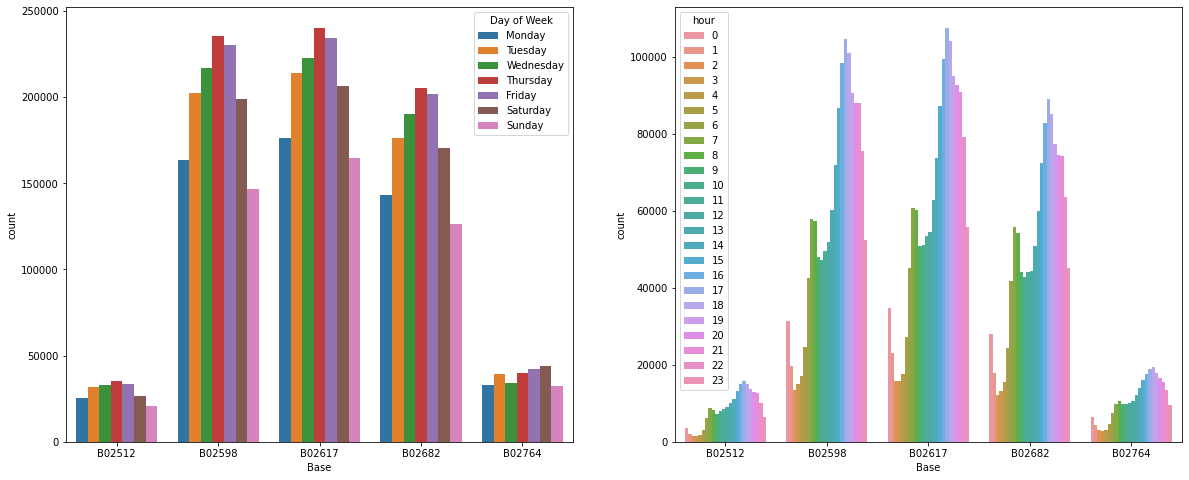

In [190]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
sns.countplot(data=raw,x='Base',hue='dayofweek', ax=ax1,)
ax1.legend(title='Day of Week', labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
sns.countplot(data=raw,x='Base',hue='hour', ax=ax2)
plt.show()

There are large differences in ride count depending on bases, but all have a very similar pattern over time.<br>
Monday and Sunday see noticeably less activity, while top days are Thursday and Friday.<br>
Busiest hours are from 16 to 21 PM, with lowest values from 1 to 5 AM.

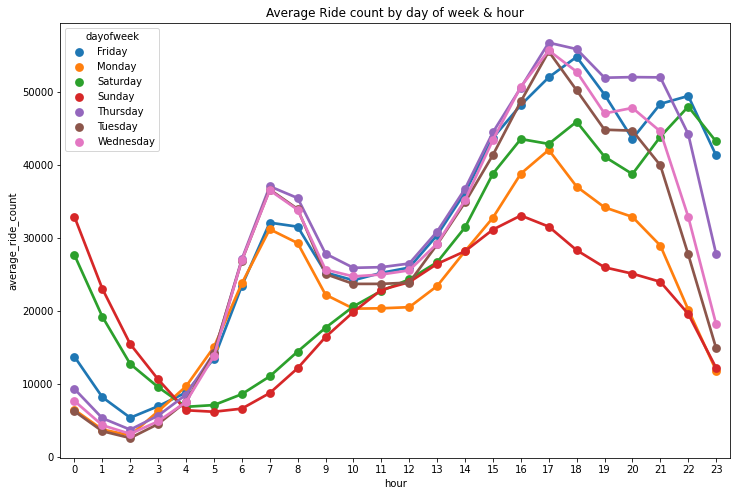

In [178]:
hourly_avg = raw.groupby(['hour','dayofweek'])['Date/Time'].count().reset_index()
daily_hourly_avg = hourly_avg.groupby(['dayofweek','hour'])['Date/Time'].mean().reset_index().rename(columns = {'Date/Time':'average_ride_count'})
daily_hourly_avg['dayofweek'] = daily_hourly_avg['dayofweek'].map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'})

plt.figure(figsize=(12,8))
sns.pointplot(x='hour',y='average_ride_count',hue='dayofweek', data = daily_hourly_avg).set_title('Average Ride count by day of week & hour')
plt.show()

There is a first peak 5 to 9 AM from Monday to Friday and another (even more from Tuesday to Saturday) starting its rise at 13 and peaking around 16 to 21 AM

Saturdays & Sundays are the only days with still high average around midnight and low average on mornings, consistent with week-end activity.

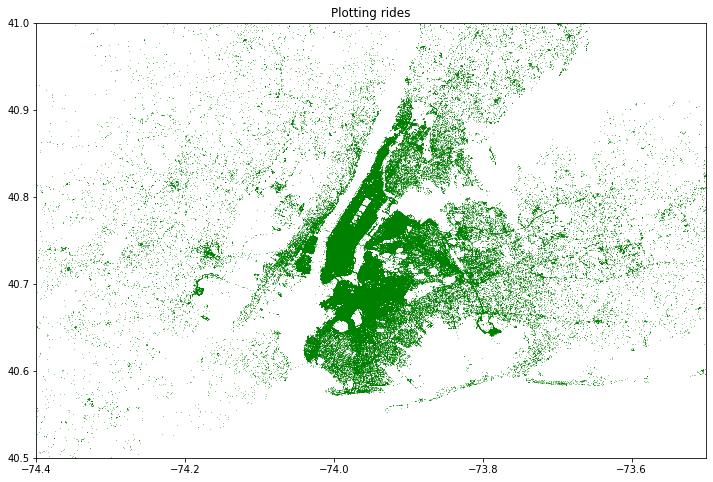

In [340]:
plt.figure(figsize=(12,8))
plt.plot(raw['Lon'], raw['Lat'], 'g+', ms = 0.2)
plt.xlim(-74.4, -73.5)
plt.ylim(40.5, 41)
plt.title('Plotting rides')
plt.show()

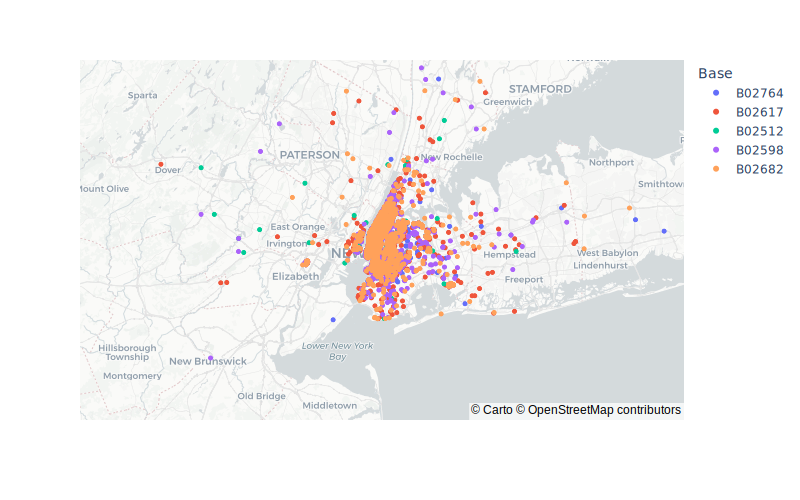

In [8]:
sample = raw.sample(n=10000, weights='hour', random_state=1)
fig = px.scatter_mapbox(sample,lat='Lat',lon='Lon',color='Base',zoom=8,mapbox_style="carto-positron",width=800)
fig.show()

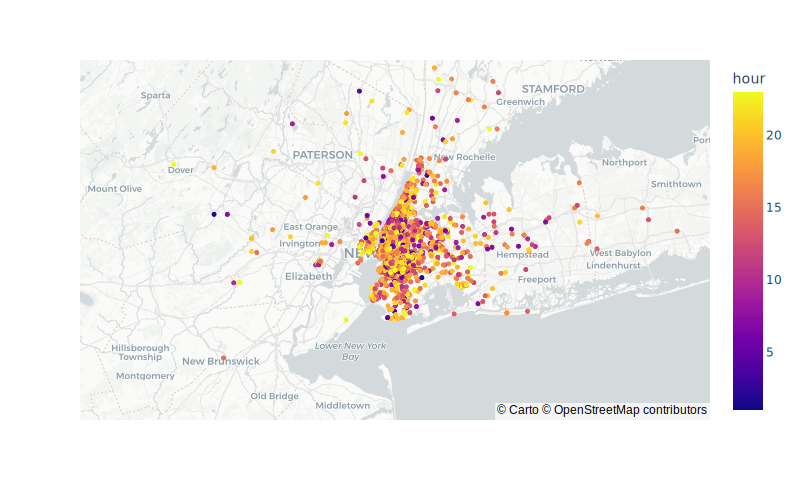

In [49]:
fig = px.scatter_mapbox(sample,lat='Lat',lon='Lon',color='hour',zoom=8,mapbox_style="carto-positron",width=800)
fig.show()

A quick overview of global base & hourly activity doesn't tell us much at this point, beyond the fact that most is concentrated on Manhattan, Northern Brooklyn and Western Bronx.

### II. Clustering
#### 1. Preprocessing

In [8]:
scaler = StandardScaler()
num = ['Lat','Lon']
X = scaler.fit_transform(raw[num])

sample_x = raw.sample(n=int((len(raw)/20)), weights='hour', random_state=1)
sample_X = scaler.fit_transform(sample_x[num])
# creating a sample for later use in DBSCAN to reduce computing time

#### 2. KMeans : Determining n_clusters & implementation

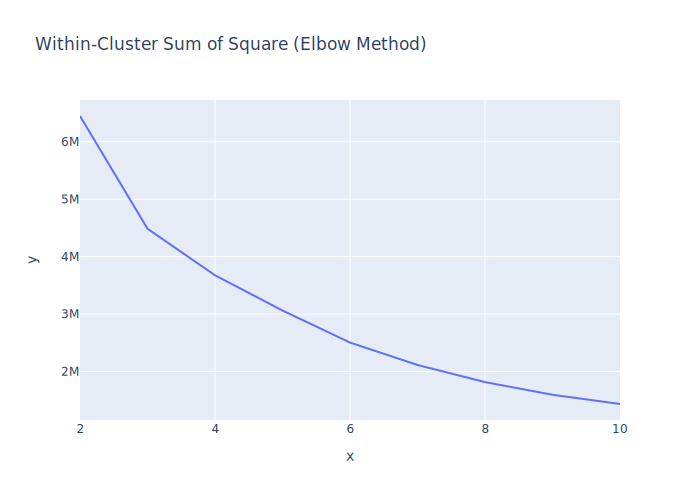

In [28]:
wcss =  []
for i in range (2,11): 
    kmeans = KMeans(n_clusters= i, random_state = 1)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

fig = px.line(x = range(2,11), y = wcss, title='Within-Cluster Sum of Square (Elbow Method)')
fig.show()

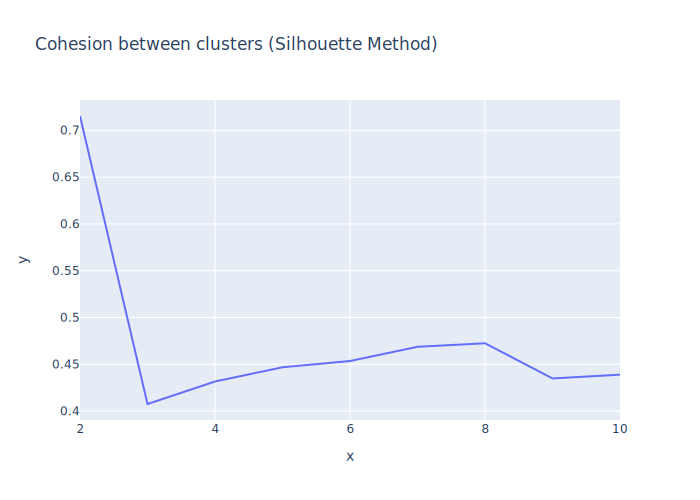

In [23]:
sil = []
for i in range (2,11): 
    kmeans = KMeans(n_clusters= i, random_state = 1)
    kmeans.fit(sample_X)
    sil.append(silhouette_score(sample_X, kmeans.predict(sample_X)))

fig = px.line(x = range(2,11), y = sil,title='Cohesion between clusters (Silhouette Method)')
fig.show()

Given what we know about the data and the objective, going for 2 clusters doesn't make sense. 6 seems like a decent choice, 9 could be interesting as well.

In [193]:
kmeans = KMeans(n_clusters=6,max_iter=300,random_state=1)
kmeans.fit(X)
np.unique(kmeans.labels_,return_counts=True)

(array([0, 1, 2, 3, 4, 5]),
 array([ 431245, 1728302,  147574,   44666, 1945441,  237099], dtype=int64))

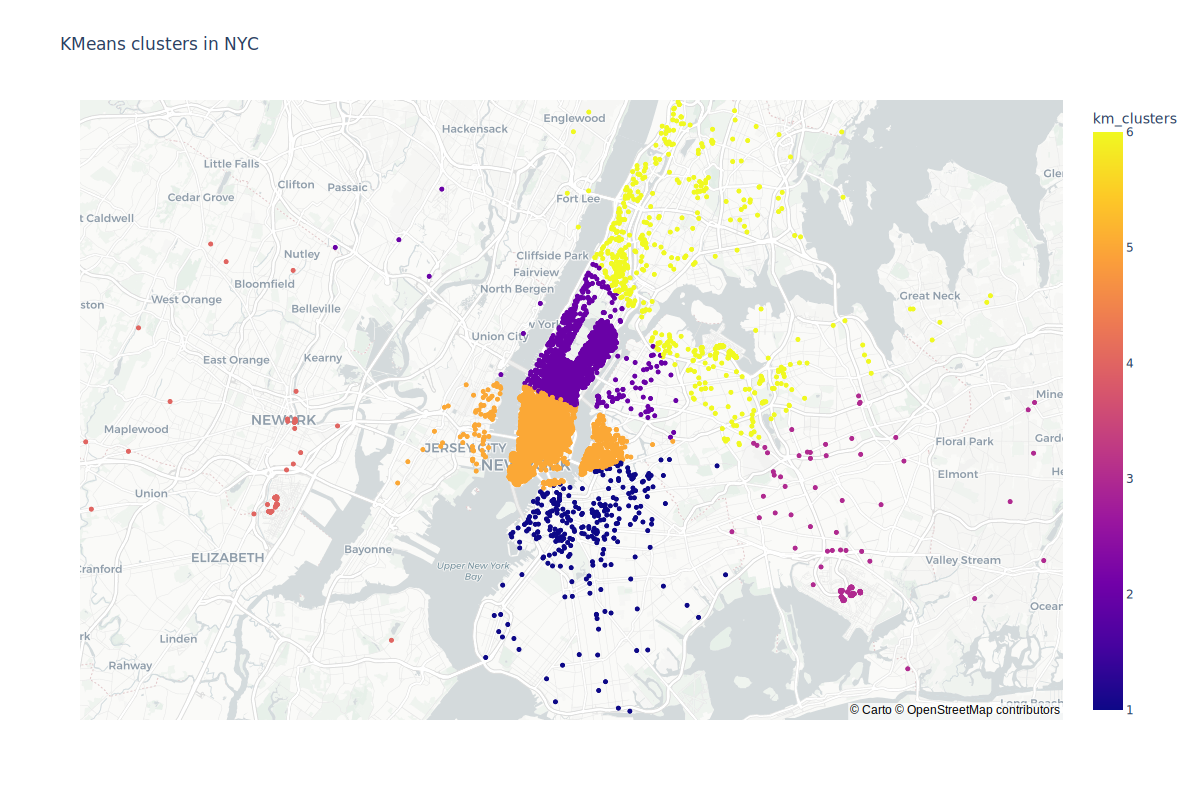

In [194]:
raw['km_clusters'] = kmeans.labels_
raw['km_clusters'] += 1
# Applying +1 to clusters (here and in other clusters below) to keep cluster "0" in the sampling.
km_sample = raw.sample(n=10000, weights='km_clusters', random_state=1)

fig = px.scatter_mapbox(km_sample,lat='Lat',lon='Lon',color='km_clusters',
                        zoom=10,mapbox_style="carto-positron",width=1200,height=800, 
                        title='KMeans clusters in NYC')
fig.show()

K-Means clustering basically gives us a center in Queens around Forest Hills from which all clusters start except n°5, which is made up of scattered points to the East : Newark.
Clusters in NYC itself roughly match boroughs, but that's not very helpful.<br>
Clustering with 9 further divided some areas but did not isolate any useful information.

#### 3. Gaussian Mixture

In [263]:
gm = GaussianMixture(n_components=9, random_state=1)
gm.fit(X)
np.unique(gm.predict(X),return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64),
 array([1654139,  594612,  103969, 1340346,  180355,   35261,   82971,
         396212,  146462], dtype=int64))

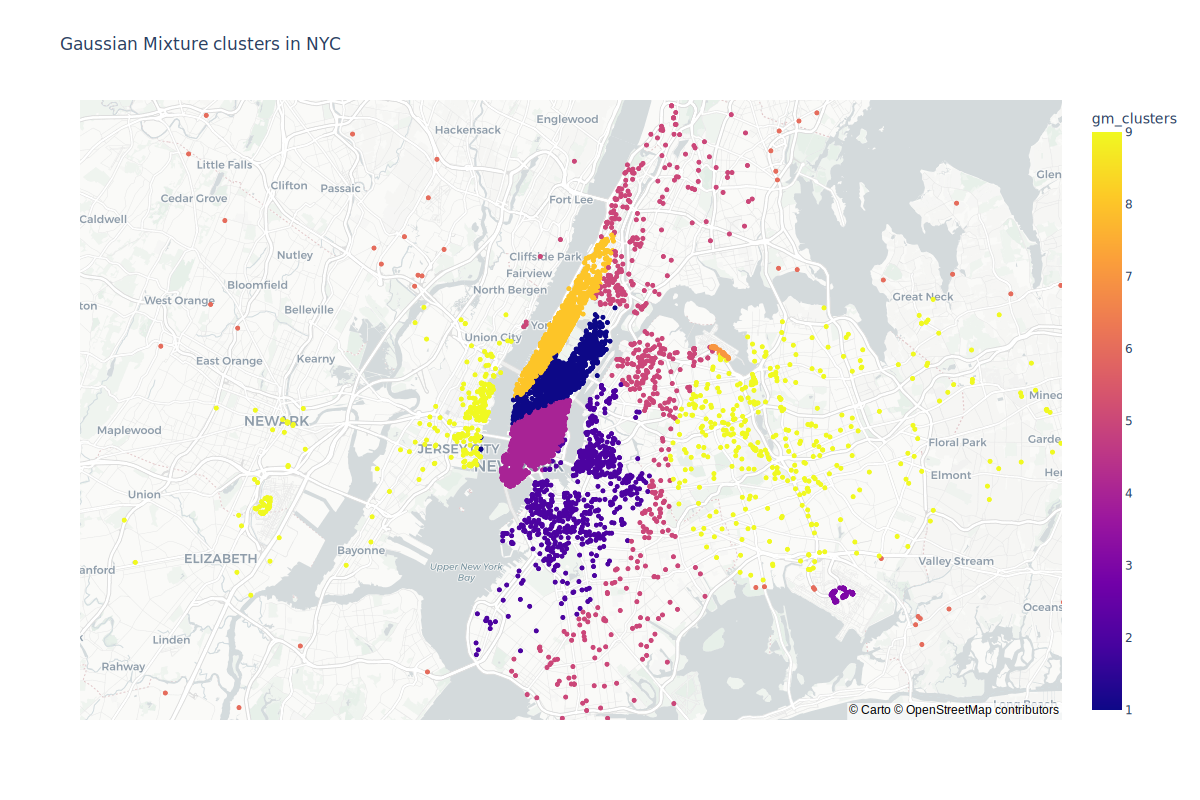

In [266]:
raw['gm_clusters'] = gm.predict(X)
raw['gm_clusters'] += 1
gm_sample = raw.sample(n=10000, weights='gm_clusters', random_state=1)

fig = px.scatter_mapbox(gm_sample,lat='Lat',lon='Lon',color='gm_clusters',
                        zoom=10,mapbox_style="carto-positron",width=1200,height=800, 
                        title='Gaussian Mixture clusters in NYC')
fig.show()

That looks more interesting !
Manhattan is divided into 3 main areas : Lower Manhattan (n°4), Midtown Manhattan & Upper East Side (n°1), Upper West Side & Harlem (n°8).<br>
Another big cluster (n°2) is in Northern Brooklyn.<br>
Most importantly, the Gaussian Mixture helps us identify a small cluster (n°3 on the map) not focusing on Manhattan, but to the South-East of Queens. What is it ? JFK Airport ! That seems relevant...<br>
We still have a lot of noise though and have only isolated 1 important location beyond main Manhattan areas.

#### 4. DBSCAN

In [292]:
dbscan = DBSCAN(eps=0.1,metric='manhattan',min_samples=200)
dbscan.fit(sample_X)
np.unique(dbscan.labels_,return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([ 19146, 171238,  12286,   4615,    506,   9470,   5500,   1227,
          1557,    615,    247,    309], dtype=int64))

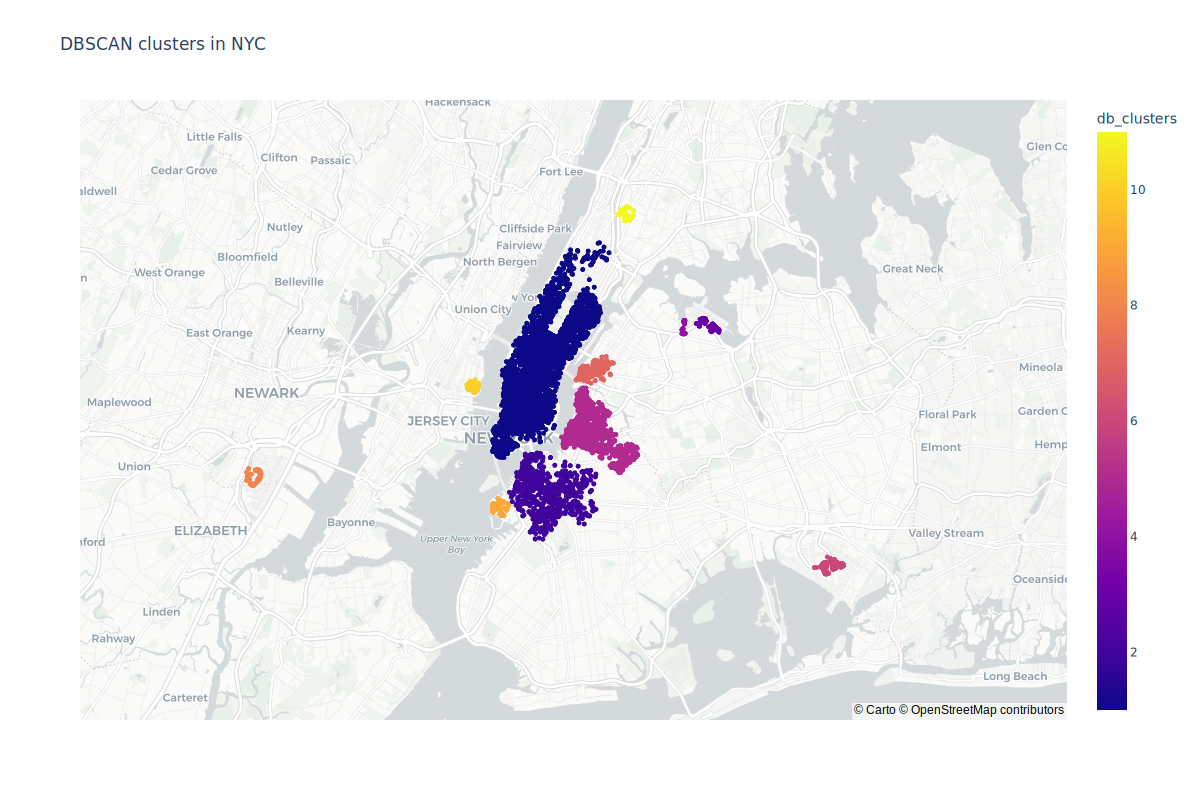

In [142]:
# Ignoring cluster -1 : outliers
sample_x['db_clusters'] = dbscan.labels_
sample_x['db_clusters'] += 1
db_sample = sample_x.sample(n=10000, weights='db_clusters', random_state=1)

fig = px.scatter_mapbox(db_sample,lat='Lat',lon='Lon',color='db_clusters',
                        zoom=10,mapbox_style="carto-positron",width=1200,height=800, 
                        title='DBSCAN clusters in NYC')
fig.show()

With DBSCAN, we're forced to use a sample to reduce computing time, but there are interesting results. With most noise removed, we have much smaller areas on which to concentrate our attention.<br>
1 = a big cluster with most of Manhattan, so that's not very surprising... But beyond that, we have :<br>
2 = Downtown Brooklyn to Prospect Heights<br>
3 & 4 = Northern Queens... That's La Guardia Airport ! Terminal C and A make up 2 different clusters<br>
5 = Northern Brooklyn : Williamsburg to Greenpoint and Bushwick<br>
6 = JFK Airport, that we noticed before with the Gaussian Mixture <br>
7 = Northwestern Queens : Hunterspoint avenue, subway & train station. Long Island train station<br>
8 = What's that so far West ? Newark Airport !<br>
9 = North-West Brooklyn : Erie Basin & Red Hook waterfront<br>
10 = Hoboken, Jersey City<br>
11 = Yankee Stadium<br>

### III. Comparing results

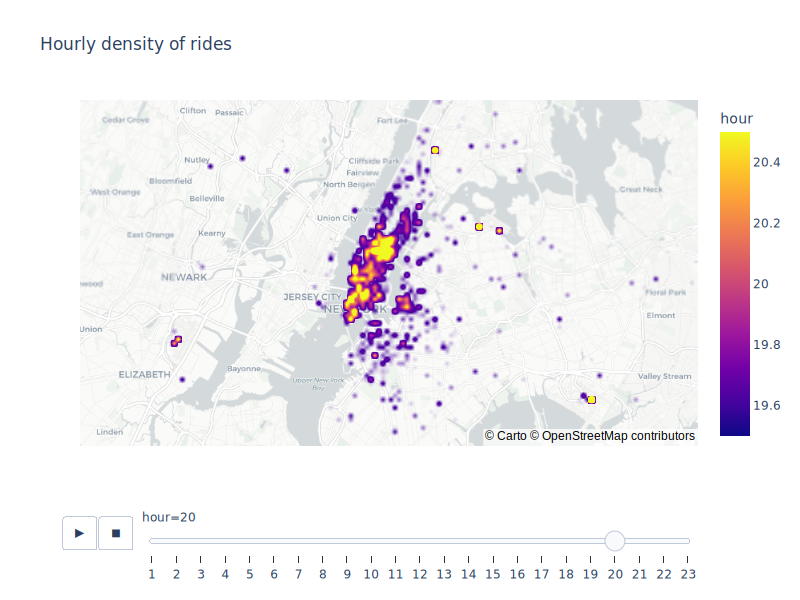

In [299]:
sample_x = sample_x.sort_values(by='hour')
fig = px.density_mapbox(sample_x, lat = 'Lat', lon = 'Lon', z = 'hour', radius = 1,
                        mapbox_style='carto-positron',animation_frame = "hour",
                        width=800, height=600,title = 'Hourly density of rides', zoom=9.5
                       )
# the 4 lines below only serve to fix the slider at a given hour, since the interactive map can't be shown on Github and the first frame (at 1 AM) wouldn't show much
def_hour = 19
fig.layout['sliders'][0]['active'] = def_hour
fig = go.Figure(data=fig['frames'][def_hour]['data'], frames=fig['frames'], layout=fig.layout)

fig.show()

We can see that our clusters match very well with the density of rides at various hours. <br>
However, this is just general information that can't really be used as it is for a recommendation. We will have to build something that actually provides centroids of clusters for a given time.

### IV. Production
Getting recommendations for a given time

In [228]:
def uber_hotzones_nyc(max_distance,min_pickups,data,hour,day):
    #This is a modified version of code by Prof. Geoff Boeing, found here : https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/

    # filter on hour   
    sample_data = data[data['hour']==hour]
    # filter on day
    days = {'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
    sample_day = days[day]
    sample_data = sample_data[sample_data['day']==sample_day]
    # get coordinates 
    coords = sample_data[['Lat', 'Lon']].to_numpy()
    x_coords = scaler.fit_transform(coords)

    # Clustering model
    db = DBSCAN(eps=max_distance, min_samples=min_pickups, metric='manhattan').fit(x_coords)
    
    # grouping clusters
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])

    # initializing lists for hot spots
    lat = []
    lon = []
    num_members = []
    
    # loop through clusters and get centroids, number of members
    for i in range(len(clusters)):
        # filter empty clusters
        if clusters[i].any():
        # get centroid and magnitude of cluster
            lat.append(MultiPoint(clusters[i]).centroid.x)
            lon.append(MultiPoint(clusters[i]).centroid.y)
            num_members.append(len(clusters[i]))

    #output
    print(f'Number of recommended hot-zones: {num_clusters}')
    #plot on map
    fig = px.scatter_mapbox(lat=lat,lon=lon,
                            color=np.log(num_members),zoom=10,mapbox_style="carto-positron",
                            width=1000,height=800, title=f'DBSCAN clusters in NYC on {day} at {hour}',
                            labels={'color':'Hotness'})
    fig.show()

Defining a function to determine, plot & recommend hot zones for a given day and hour

Number of recommended hot-zones: 19


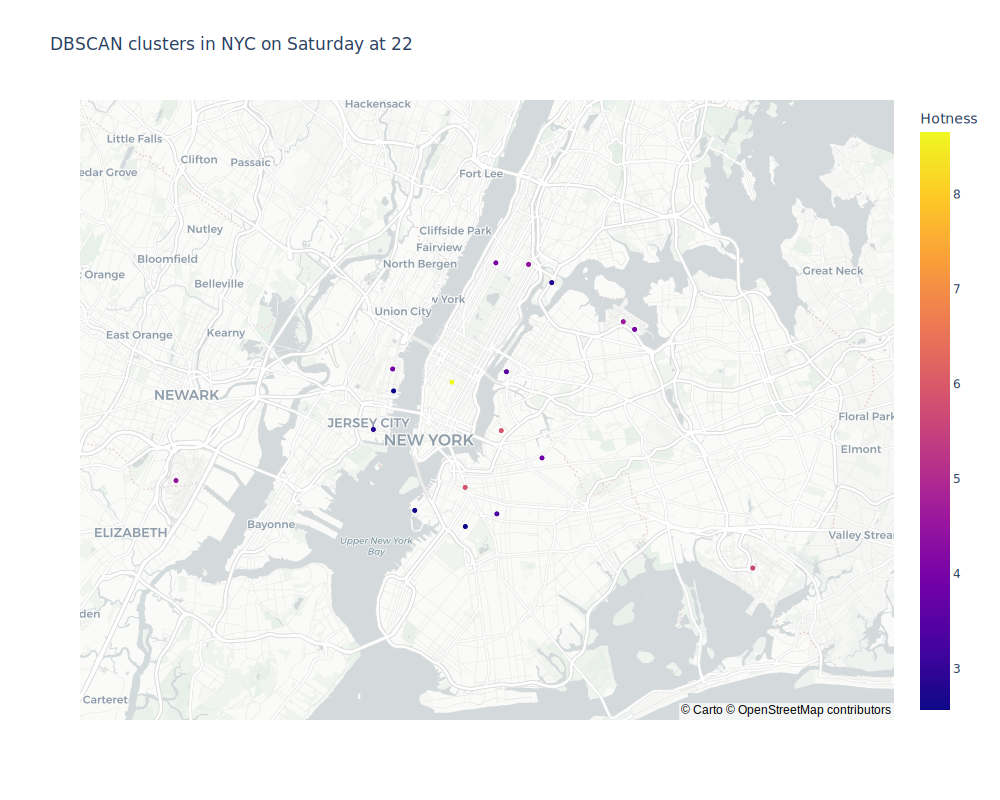

In [240]:
max_distance = 0.1
min_pickups = 10 #lower value : the sample for a given day at a given hour is considerably smaller
hour = 22
day = 'Saturday'
uber_hotzones_nyc(max_distance,min_pickups,raw,hour,day)

And there we have it ! 19 recommendations for hot-zones on Saturdays at 22PM. No surprise the "hottest" is in Manhattan (near Madison Square in this case), but there are very good secondary hot-zones in Williamsburg & Prospect Heights (Brooklyn), as well as LGA, JFK & Newark Airports.

### V. Conclusions

Overall, DBSCAN required a little more tuning to implement (sampling, parameters) but produced much more interesting results and provided clearly identifiable hot spots

Uber is widely used in New York City.<br>
In Manhattan, there is so much activity that drivers are active almost everywhere at most times. This might tell us that higher income areas result in more Uber requests, but it would have to be explored further to establish with more certainty. <br>
We were however also able to identify more discriminately some areas of interest in more distant locations that are useful to provide recommendations to Uber drivers, especially when busy hours with likely heavy traffic could make Manhattan a sub-optimal choice.<br>

To go further & improve our recommendations, we could gather more data : could weather an important factor ?